In [11]:
from elasticsearch import Elasticsearch
import urllib3
urllib3.disable_warnings()


es = Elasticsearch(
    ['https://86dd17d952698a0f90485f28a0087669.eu-west-1.aws.found.io'],
    port=9243,
    http_auth='elastic:9X4hmUZXasOBuF49ujcGBqLS',
    verify_certs=False
)

es.cluster.health()


{u'active_primary_shards': 5,
 u'active_shards': 10,
 u'active_shards_percent_as_number': 100.0,
 u'cluster_name': u'86dd17d952698a0f90485f28a0087669',
 u'delayed_unassigned_shards': 0,
 u'initializing_shards': 0,
 u'number_of_data_nodes': 2,
 u'number_of_in_flight_fetch': 0,
 u'number_of_nodes': 3,
 u'number_of_pending_tasks': 0,
 u'relocating_shards': 0,
 u'status': u'green',
 u'task_max_waiting_in_queue_millis': 0,
 u'timed_out': False,
 u'unassigned_shards': 0}

In [15]:
import uuid
str(uuid.uuid4())

data_centres = ["data centre a",
                "data centre b",
                "data centre c",
                "data centre d",
                "data centre e"]

event_types = ["transfer-queued", "transfer-success", "transfer-failed"]

import datetime
datetime.datetime.now().replace(microsecond=0).isoformat()

#event={}

'2017-03-12T21:58:53'

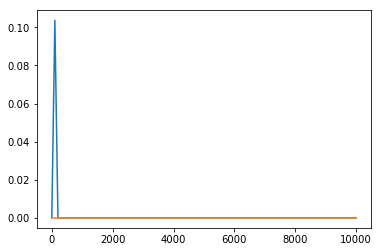

In [21]:
import numpy as np

import random
mu1, sigma1=100, 0.5
mu2, sigma2=2000, 0.5
mu3, sigma3=5000, 0.5
random.gauss(mu1, sigma1)

s = np.random.normal(mu1, sigma1, 1000)
s = np.random.normal(mu2, sigma2, 1000)
s = np.random.normal(mu3, sigma3, 1000)
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

x = np.linspace(0, 10000, 100)
plt.plot(x,mlab.normpdf(x, mu1, sigma1))
plt.plot(x,mlab.normpdf(x, mu2, sigma2))
plt.plot(x,mlab.normpdf(x, mu3, sigma3))
plt.show()